# CIVP - 저작권 검증모델 
## 1. 학습 준비
 - 필요한 library 적용(tensorflow, keras, sklearn, seaborn 등)

In [1]:
from tensorflow import keras # tensorflow.keras모듈
import numpy as np
import pandas as pd
import re
import random
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

- 수집된 UCI_code 데이터 10000개 단위로 불러오기(2469개 chunk)

In [2]:
chunk_df = pd.read_csv('./uci_code.csv', chunksize=10000)
chunk = list(chunk_df)

- 모델에 필요한 정보가 있는 data 선별

In [3]:
# 모델에 필요한 정보가 있는 data 선별

a_list = list()
for i, df in enumerate(chunk):
    if df['issue_date'].isna().sum() != len(chunk[i]):
        a_list.append(i)
        # print(df['issue_date'].isna().sum())
        
print(a_list)

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [4]:
df = pd.concat(chunk[6:18])
df.shape

(120000, 23)

In [6]:
df2 = df[['song','resister_date', 'issue_date', 'singer','album_singer']]
df3 = df2.dropna()

In [7]:
# df[df['composer'].notnull()]['composer']
# df[df['distributor'].notnull()]
# df3['album_singer']
chunk[300]

,id,uci_code,song,resister_date,page,state,album,issue_date,distributor,cd_num,...,album_singer,UPC,production_company,track_num,singer,ISRC,lyricist,arranger,playtime,featuring
3000000,3018234,i500-1000006512642.100037292117-1,Hernando's Hideaway (Strict Tempo),2020-07-12,293184,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000001,3018235,i500-1000004883841.100051669886-1,Iron Man 3 - The Film Trailer Soundtrac...,2020-07-12,293181,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000002,3018236,i500-1000005035375.100051669779-1,Lead Me Not Into Temptation,2020-07-12,293179,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000003,3018237,i500-1000006512642.100037241024-1,Blue Tango (Strict Tempo),2020-07-12,293184,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000004,3018238,i500-1000004883841.100051669876-1,"I've Got No Strings (From the ""Avengers...",2020-07-12,293182,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009995,3028229,i500-1000006511859.100051660714-1,Float Away,2020-07-11,294180,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3009996,3028230,i500-1000006511854.100051660642-1,Too Hot (feat. Lisa Stansfield),2020-07-11,294185,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3009997,3028231,i500-1000006511859.100051660713-1,Mama Needs a Girls Night Out,2020-07-11,294180,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3009998,3028232,i500-1000006511854.100051660641-1,Hearthache to Hearthache,2020-07-11,294185,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 데이터 형식 변환 및 처리
df3['issue_date'] = pd.to_datetime(df3['issue_date'])
df3['resister_date'] = pd.to_datetime(df3['resister_date'])
df3['date_diff'] = (df3['issue_date'] - df3['resister_date']).dt.days
df3['date_diff2'] = [1 if s > 0 else ( -1 if s < 0 else 0) for s in df3['date_diff']]
df3['date_same'] = (df3['issue_date'] == df3['resister_date']).astype(int)
df3['singer_same'] = (df3['singer'] == df3['album_singer']).astype(int)
df3['eng_kor'] = [0 if re.sub('[^A-Za-z]', '', s) else 1 for s in df3['singer']]
df3['y'] = df3['date_same'] * df3['singer_same']

C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

## 2. 학습데이터 준비 및 분포 확인
- 독립변수로 저작권등록일과 발매일의 차이 / 외국가수와 한국가수 여부를 범주화
- 종속변수로 등록일과 발매일, 가수와 저작권자가 동일한 경우를 통한 저작권 검증 문제 여부

In [9]:
# 학습데이터 중에서 검증을 위한 테스트 데이터 20%
x = df3[['date_diff2', 'eng_kor']]
y = df3['y']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10, shuffle = True)
len(X_train), len(X_test), len(y_train), len(y_test)

(81912, 20479, 81912, 20479)

- 학습데이터 분포 시각화

C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\user\anaconda3\envs\CIVP-flow_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

<AxesSubplot:xlabel='y', ylabel='count'>

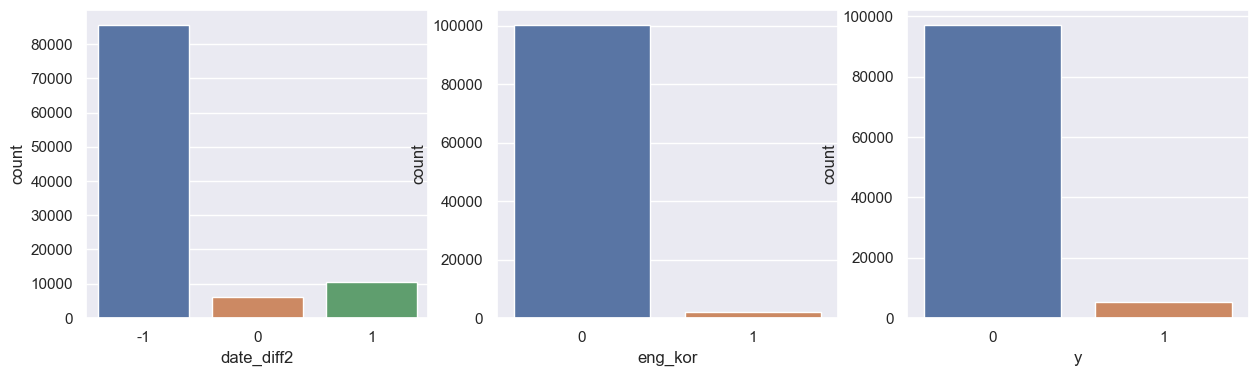

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
sns.countplot(df3['date_diff2'], ax=axs[0])
sns.countplot(df3['eng_kor'], ax=axs[1])
sns.countplot(df3['y'], ax=axs[2])

In [11]:
df["issue_date"] = df["issue_date"].astype("datetime64")
df3['y']

68123     0
68124     0
68125     0
68126     0
68127     0
         ..
173408    1
173409    1
173410    1
173411    1
173412    1
Name: y, Length: 102391, dtype: int32

In [12]:
df["issue_date"]

60000    NaT
60001    NaT
60002    NaT
60003    NaT
60004    NaT
          ..
179995   NaT
179996   NaT
179997   NaT
179998   NaT
179999   NaT
Name: issue_date, Length: 120000, dtype: datetime64[ns]

<AxesSubplot:xlabel='issue_date'>

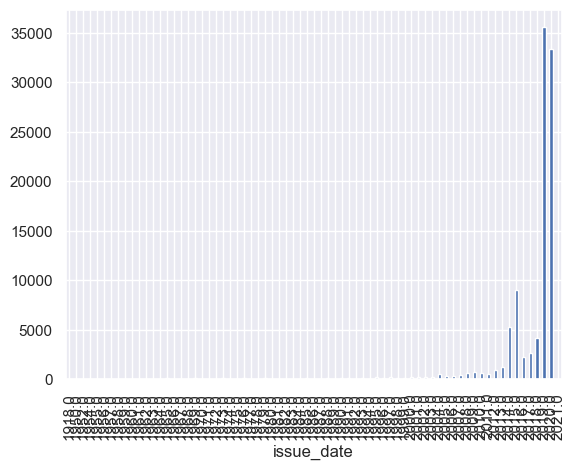

In [13]:
df["issue_date"].groupby(df["issue_date"].dt.year).count().plot(kind="bar")

## 3. 모델 학습 및 결과 평가
> 기본적인 MLP(multilayer perceptron model) 구조

* hidden layer 2개층(각 10, 5 node)

* activation function : relu, sigmoid

* optimizer : adam 






In [14]:
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

> 모델 학습
* 10 epochs, batch size 100

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=10, batch_size=100)

Epoch 1/10
820/820 [==============================] - 1s 1ms/step - loss: 0.1911 - accuracy: 0.9499 - val_loss: 0.0927 - val_accuracy: 0.9490
Epoch 2/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0619 - accuracy: 0.9499 - val_loss: 0.0464 - val_accuracy: 0.9490
Epoch 3/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0396 - val_accuracy: 0.9889
Epoch 4/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0360 - accuracy: 0.9896 - val_loss: 0.0349 - val_accuracy: 0.9889
Epoch 5/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0319 - val_accuracy: 0.9889
Epoch 6/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0298 - accuracy: 0.9896 - val_loss: 0.0302 - val_accuracy: 0.9889
Epoch 7/10
820/820 [==============================] - 1s 1ms/step - loss: 0.0285 - accuracy: 0.9896 - val_loss: 0.0295 - val_accuracy: 0.9889
Epoch 

> 테스트데이터를 통한 모델 성능 평가

In [16]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

640/640 [==============================] - 1s 893us/step - loss: 0.0291 - accuracy: 0.9889
Accuracy: 98.89


> 학습결과를 그래프로 확인

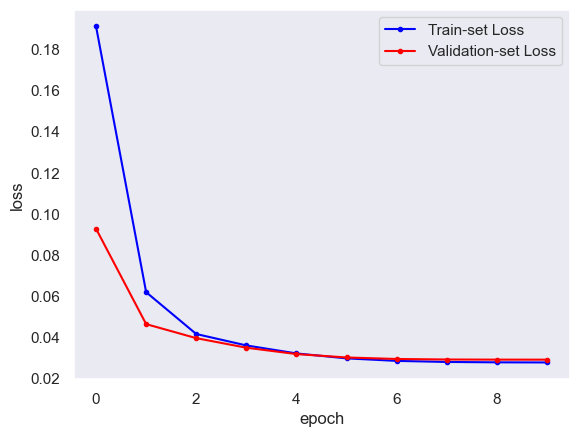

In [17]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

##### > 학습에 걸리는 시간 측정
* 테스트 데이터 대상 5번 반복해서 평균 측정

In [18]:
import time
start_time = time.time()
for i in range(5):
    y_test_pred = model.predict(X_test)
    y_test_pred = np.around(y_test_pred)

print("average inference time: {:.3f}".format((time.time()-start_time) / 10))

average inference time: 0.339


In [19]:
X_test.shape

(20479, 2)

> 히트맵을 그려서 모델성능 시각화

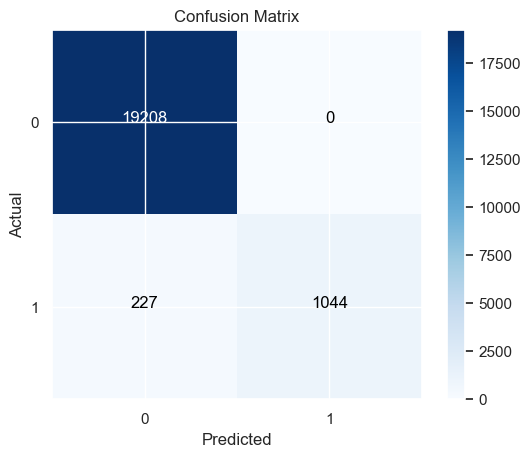

In [21]:
import itertools
cf = confusion_matrix(y_test_pred, y_test)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

> 모델 f1-score 측정

In [22]:
report = classification_report(y_test, y_test_pred, target_names=['certain', 'uncertain'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
f1_score = report_df.loc["accuracy","f1-score"]
print("test_f1_score: {:.3f}".format(f1_score))

test_f1_score: 0.989


##### > 예측 평균 정확도 측정
* 테스트 데이터 대상 5번 반복해서 평균 측정

In [23]:
test_num = 5
dataset_index_list = list(X_test.index)

f1_score_list = []

for test_idx in range(test_num):
    random_index_list = random.sample(dataset_index_list, 5000)
    y_test_pred = model.predict(X_test.loc[random_index_list])
    y_test_pred = np.around(y_test_pred)
    
    report = classification_report(y_test.loc[random_index_list], y_test_pred, target_names=['certain', 'uncertain'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    f1_score = report_df.loc["accuracy","f1-score"]
    f1_score_list.append(f1_score)
    print("[{}] test_f1_score: {:.3f}".format(test_idx+1, f1_score))
    
print("test_f1_score: {:.3f}".format(np.mean(f1_score_list)))

[1] test_f1_score: 0.990
[2] test_f1_score: 0.988
[3] test_f1_score: 0.988
[4] test_f1_score: 0.991
[5] test_f1_score: 0.987
test_f1_score: 0.989
